In [75]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [76]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t


def lp_norm_loss(y, yhat, p=2):
    return torch.norm(y-yhat, p=p)

In [77]:
# setting up SIR reference data
num_hosts = 50
num_steps = 400
dt = 0.05
torch.manual_seed(666)

time_scale = 25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.75, 0.25, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

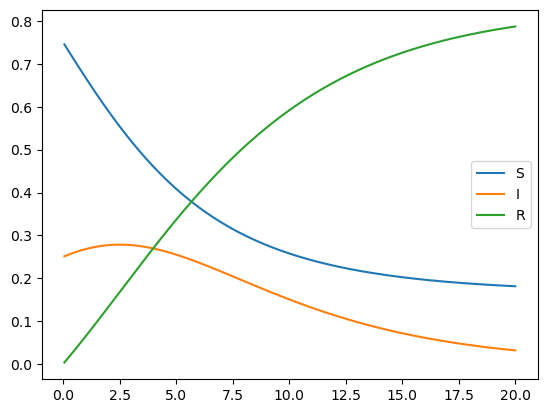

In [78]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [79]:
regularize = True
reg_weight = 0.01

beta = 4.71
delta = 1.07
p = 3.07
c = 2.3

param_train = (torch.tensor([beta, delta, p, c], dtype=torch.float32)*torch.ones(num_hosts, 4)).T.flatten()

In [80]:
num_epochs = 200

method = 'euler'
step_size = 2*dt
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

loss_function = lambda y, yhat: lp_norm_loss(y, yhat, p=2)  # nn.L1Loss()

y_train = torch.cat((SIR_train_data[0,:], SIR_train_data[1,:], SIR_train_data[2,:]))

if regularize:
    y_train = torch.cat([y_train, reg_weight*param_train])

In [81]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    y_est = torch.cat((SIR_est[0,:], SIR_est[1,:], SIR_est[2,:]))
    
    if regularize:
        param_est = torch.cat([model.nUIV_dynamics.betas, model.nUIV_dynamics.deltas, model.nUIV_dynamics.ps, model.nUIV_dynamics.cs])
        y_est = torch.cat([y_est, reg_weight*param_est])
    
    loss = loss_function(y_est, y_train.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: 18.34510612487793.
Epoch 1, loss value: 11.463627815246582.
Epoch 2, loss value: 9.93639850616455.
Epoch 3, loss value: 7.352232933044434.
Epoch 4, loss value: 3.7795586585998535.
Epoch 5, loss value: 7.286233901977539.
Epoch 6, loss value: 4.861303329467773.
Epoch 7, loss value: 3.5114457607269287.
Epoch 8, loss value: 4.5529632568359375.
Epoch 9, loss value: 4.4163432121276855.
Epoch 10, loss value: 3.183262586593628.
Epoch 11, loss value: 1.9222115278244019.
Epoch 12, loss value: 2.9304277896881104.
Epoch 13, loss value: 2.354447603225708.
Epoch 14, loss value: 1.4736114740371704.
Epoch 15, loss value: 2.166867971420288.
Epoch 16, loss value: 1.9263584613800049.
Epoch 17, loss value: 1.4521713256835938.
Epoch 18, loss value: 1.7503910064697266.
Epoch 19, loss value: 1.4185551404953003.
Epoch 20, loss value: 1.4135642051696777.
Epoch 21, loss value: 1.2711601257324219.
Epoch 22, loss value: 1.4299064874649048.
Epoch 23, loss value: 1.3127657175064087.
Epoch 24, l

In [82]:
nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

print(nUIV_params)

{'beta': array([8.6475056e-01, 4.7104206e+00, 5.1084902e-02, 4.6946359e+00,
       2.5276313e+00, 4.7910413e-01, 4.7048244e+00, 3.6957877e+00,
       4.6516700e+00, 4.6732974e+00, 1.9428377e+00, 4.6874242e+00,
       6.6327477e-01, 4.6762128e+00, 4.5073056e+00, 1.6079725e+00,
       2.6349196e+00, 4.7104931e+00, 1.9032509e+00, 1.8596621e-03,
       2.2274034e+00, 3.2687414e-01, 4.6427560e+00, 8.0225956e-01,
       1.0108225e+00, 4.7102642e+00, 4.7168155e+00, 4.7057242e+00,
       4.5566931e+00, 7.6355535e-01, 4.6747861e+00, 2.5907114e+00,
       4.7095823e+00, 3.9579425e+00, 4.7132387e+00, 9.9020249e-01,
       2.3127930e+00, 4.7030153e+00, 1.0154665e+00, 2.1422782e+00,
       3.0684960e+00, 1.6372173e+00, 4.6926422e+00, 4.4371529e+00,
       4.7015409e+00, 1.1207017e-01, 3.6746123e+00, 2.1086202e+00,
       1.7218007e-02, 3.9802402e-01], dtype=float32), 'delta': array([3.7077289e-02, 1.0701666e+00, 4.8577733e-02, 3.2586956e-03,
       5.2651387e-01, 5.1046234e-02, 1.4857570e+00, 1.164

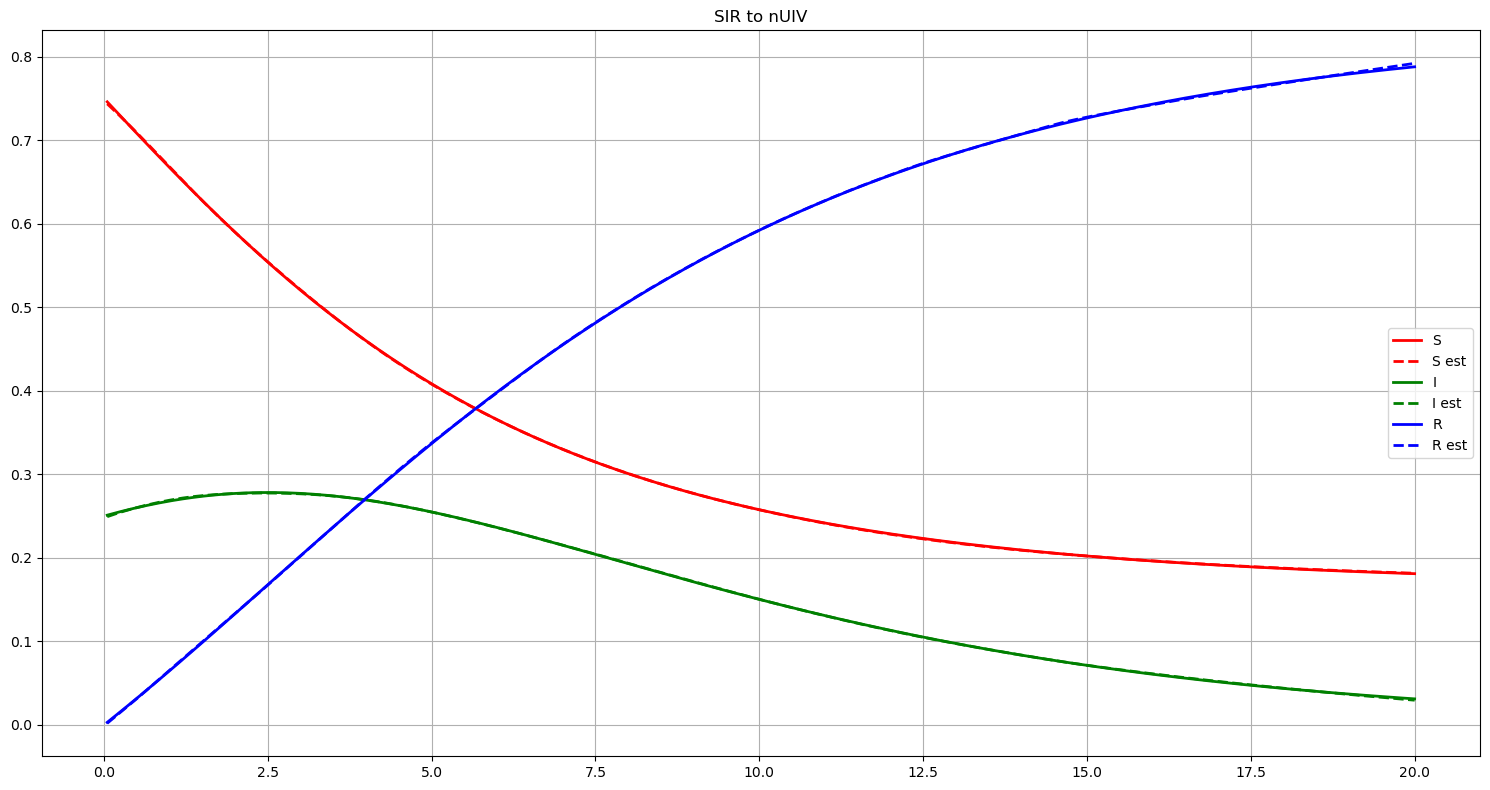

In [83]:
# SIR_stepper.reset()
# SIR_stepper.dt = 0.001
# num_steps = 20000
# SIR_test_data, time_test_data = generate_SIR_data(SIR_stepper, num_steps)

with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()
    # SIR_test_data_est = model.simulate(time_test_data.to(device)).detach().cpu().numpy()

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
f, ax1 = plt.subplots(figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
    # ax2.plot(time_test_data, SIR_test_data[i, :], lw=2, color=colors[i], label=name)
    # ax2.plot(time_test_data, SIR_test_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')


# ax1.plot(time_train_data[3:], SIR_train_data[1, 3:], lw=2, color=colors[1], label=names[1])
# ax1.plot(time_train_data[3:], SIR_train_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
# ax2.plot(time_test_data[3:], SIR_test_data[1, 3:], lw=2, color=colors[1], label=names[1])
# ax2.plot(time_test_data[3:], SIR_test_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax1.set_title('SIR to nUIV')
# ax2.set_title('Testing')
ax1.grid()
# ax2.grid()
ax1.legend()
# ax2.legend()
f.tight_layout()

path = './tmp/'
if not os.path.exists(path):
    os.mkdir(path)
filename = os.path.join(path, 'last_run_pytorch.png')
f.savefig(filename)
plt.show()

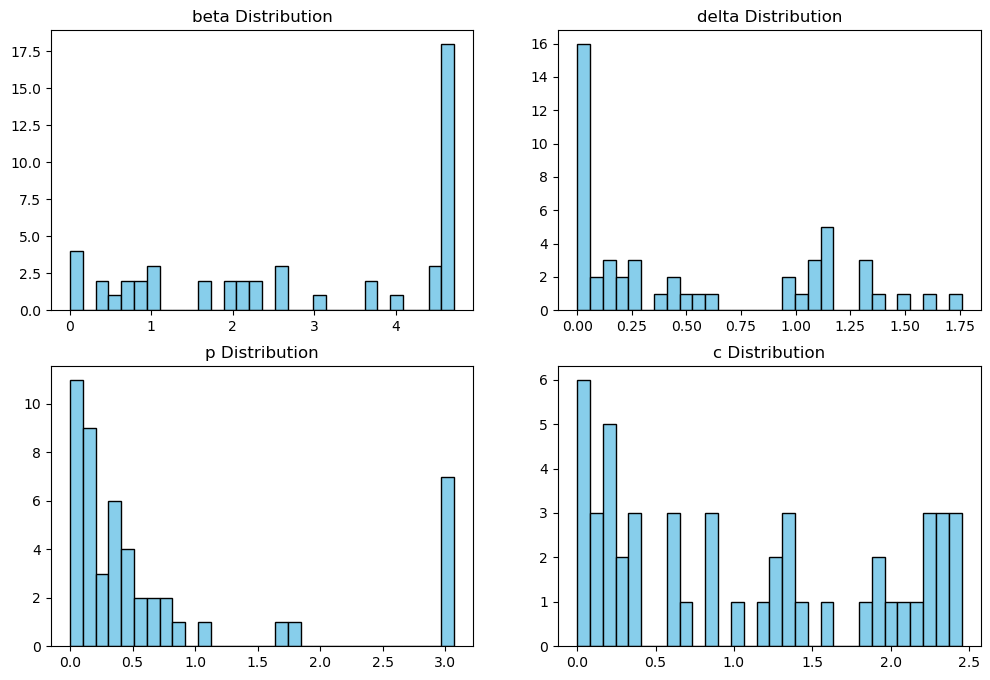

In [84]:
params = ['beta', 'delta', 'p', 'c']

plt.figure(figsize=(12,8))
for i,param in enumerate(params):
    plt.subplot(2,2,i+1)
    plt.hist(nUIV_params[param], bins=30, color='skyblue', edgecolor='black')
    plt.title(param+' Distribution')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.grid(True)
plt.show()

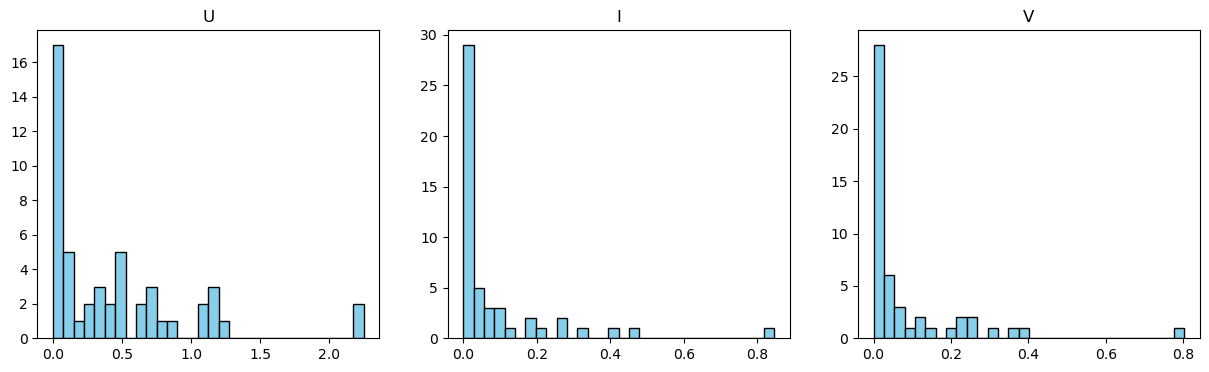

In [85]:
states= ['U', 'I', 'V']
plt.figure(figsize=(15,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(nUIV_params['x0'][i::3], bins=30, color='skyblue', edgecolor='black')
    plt.title(states[i])

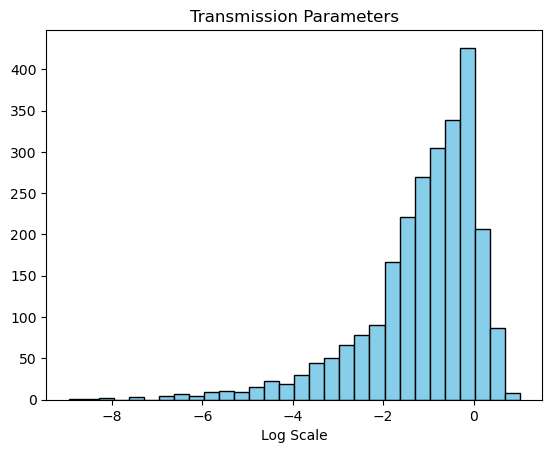

In [109]:
ts = model.nUIV_dynamics.ts.detach().flatten().numpy()
plt.hist(np.log10(ts), bins=30, color='skyblue', edgecolor='black')
plt.title("Transmission Parameters")
plt.xlabel("Log Scale")
plt.show()

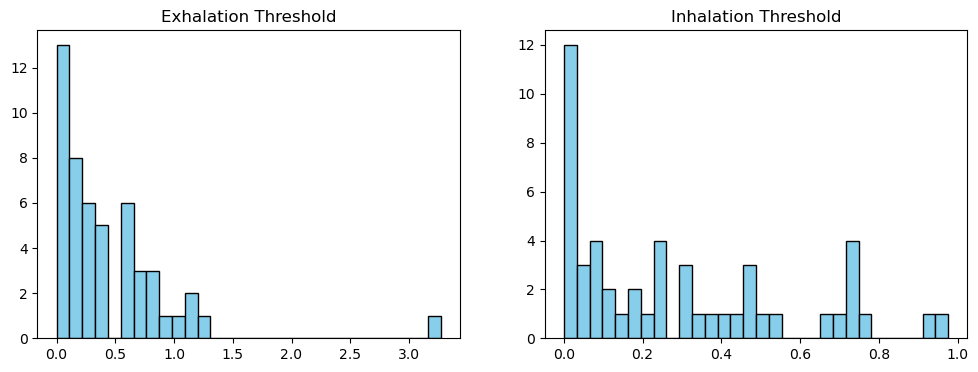

In [105]:
plt.figure(figsize=(12,4))

ex_thresh = model.nUIV_dynamics.ex_thresh.detach().flatten().numpy()
plt.subplot(1,2,1)
plt.title("Exhalation Threshold")
plt.hist(ex_thresh, bins=30, color='skyblue', edgecolor='black')

in_thresh = model.nUIV_dynamics.in_thresh.detach().flatten().numpy()
plt.subplot(1,2,2)
plt.title("Inhalation Threshold")
plt.hist(in_thresh, bins=30, color='skyblue', edgecolor='black')

plt.show()